In [1]:
!pip install torchmetrics
import numpy as np
import pandas as pd
import math
import sys
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
import os
from matplotlib.patches import Rectangle
from torchvision.transforms import Compose, ToTensor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.utils import draw_bounding_boxes
import torchvision.transforms.functional as F
from torchvision.io import read_image
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from pprint import pprint
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 29.7 MB/s eta 0:00:00


In [3]:
label_df = pd.read_csv('dataSheet.txt')
print(label_df.head())
print(label_df.shape)

          file name  abstract  square  circle  starting x  starting y  height  \
0  abstract (1).jpg         1       0       0         158         206     313   
1  abstract (2).jpg         1       0       0         245         160     280   
2  abstract (3).jpg         1       0       0         235         172     277   
3  abstract (4).jpg         1       0       0         201         148     282   
4  abstract (5).jpg         1       0       0         195         141     292   

   width  
0    263  
1     49  
2     61  
3     67  
4     80  
(269, 8)


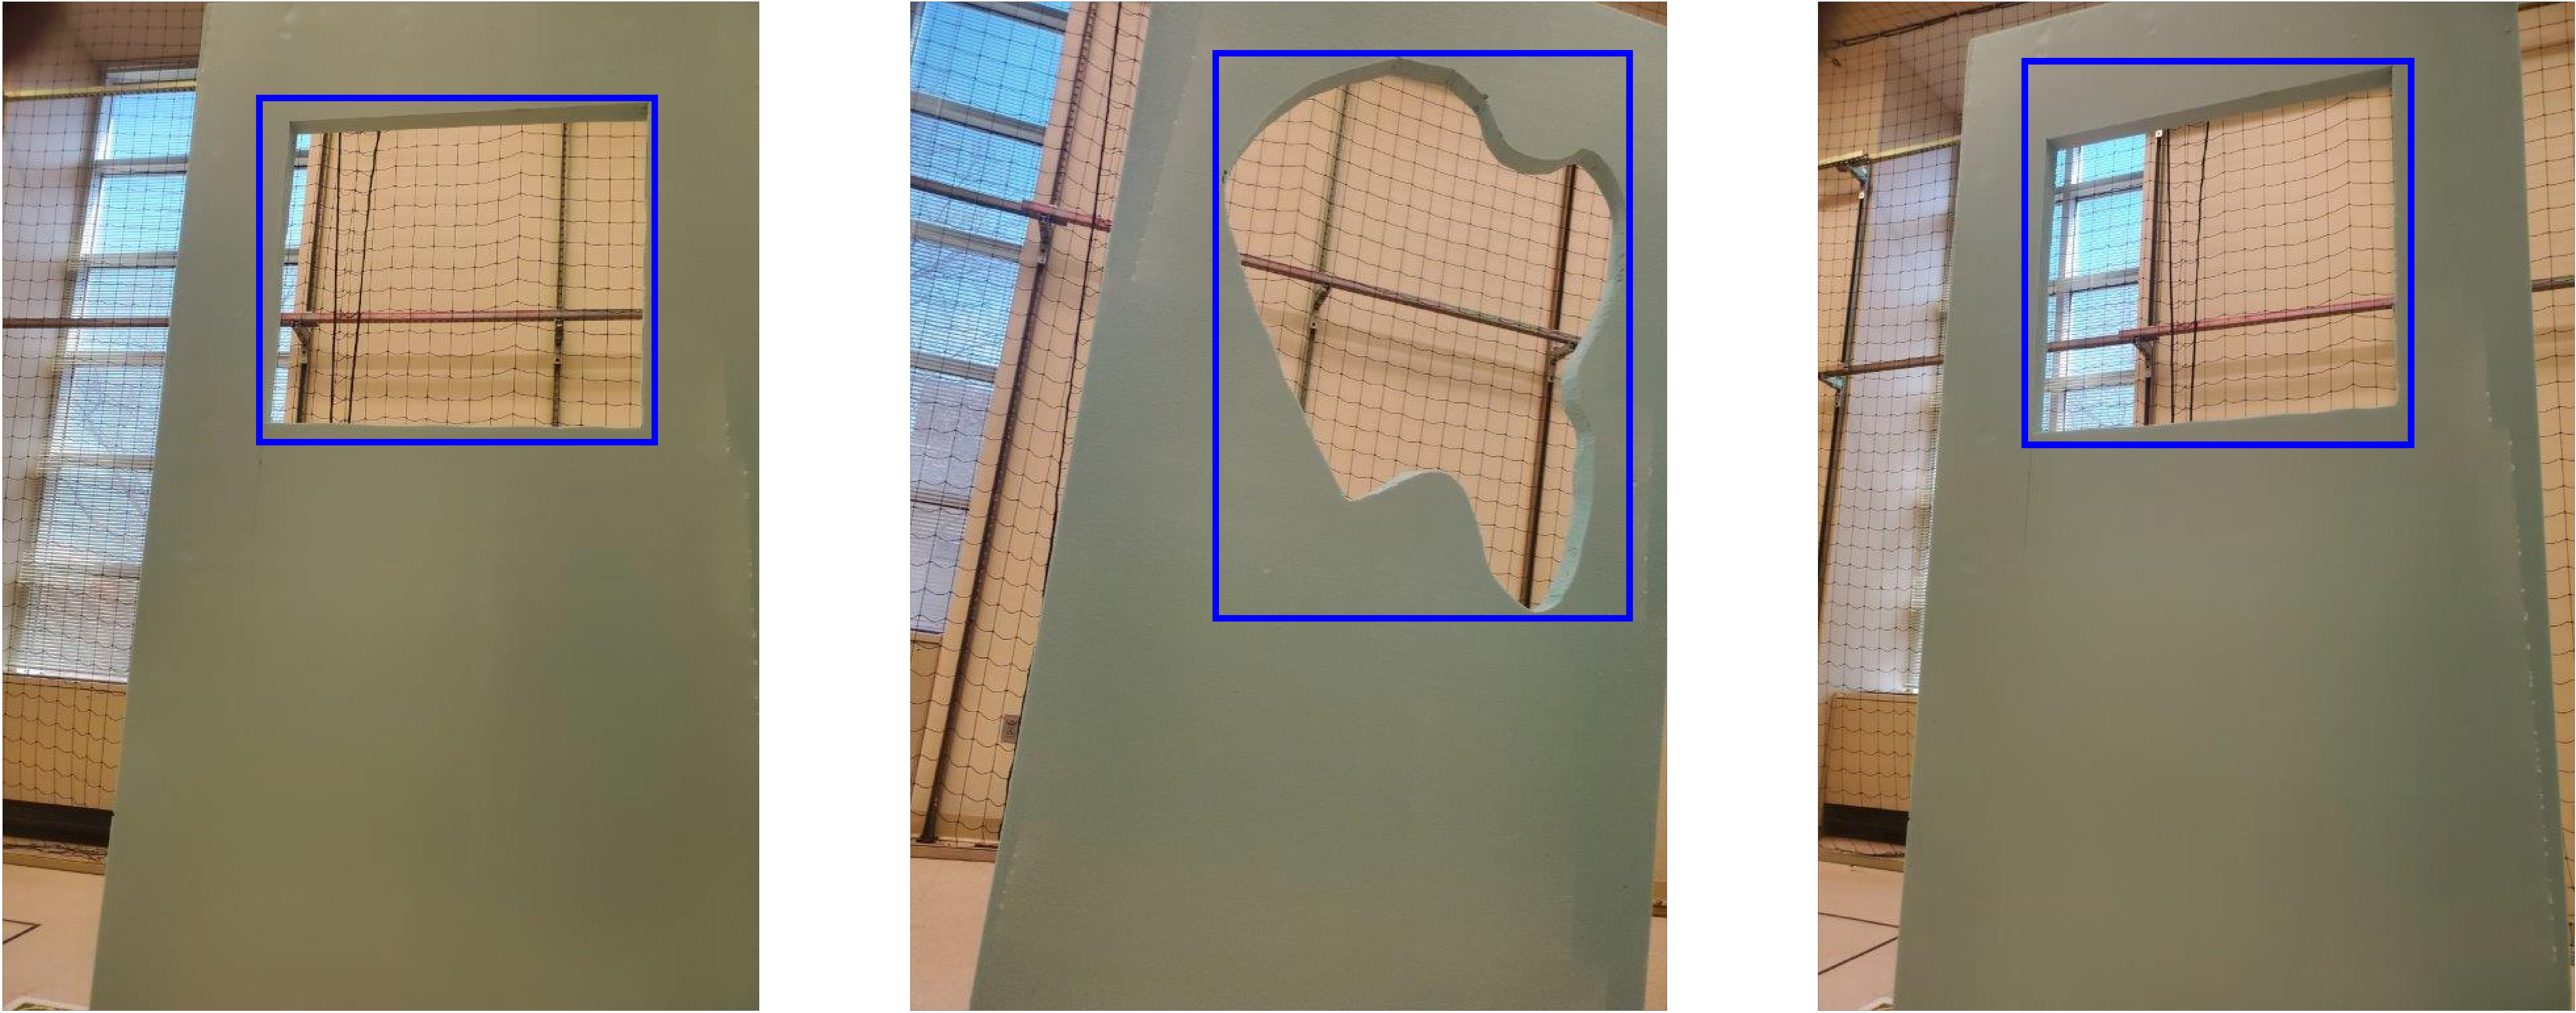

In [8]:
plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(200,200))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

idxs = torch.randperm(len(label_df)).tolist()

images = []
for idx in idxs[:3]:
    file_name = label_df['file name'][idx]
    img = read_image('./image_data/'+file_name) 
    x = label_df['starting x'][idx]
    y = label_df['starting y'][idx]
    h = label_df['height'][idx]
    w = label_df['width'][idx]
    boxes = [[x,y,x+w,y+h]]
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    img = draw_bounding_boxes(img, boxes, colors=['blue'], width=5)
    images.append(img)
show(images)

In [5]:
class GateDataset(torch.utils.data.Dataset):
    def __init__(self, root, input_transforms=None, target_transforms=None, device=None):
        self.root = root
        self.input_transforms = input_transforms
        self.target_transforms = target_transforms
        self.label_df = pd.read_csv(root+'dataSheet.txt')
        self.device = device
    def __getitem__(self, idx):
        img_path = self.root+ "image_data/"+ self.label_df['file name'][idx]
        img = Image.open(img_path).convert("RGB")
        x = self.label_df['starting x'][idx]
        y = self.label_df['starting y'][idx]
        h = self.label_df['height'][idx]
        w = self.label_df['width'][idx]
        boxes = [[x,y,x+w,y+h]]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        if self.device is not None:
            boxes = boxes.to(self.device)
        if self.label_df['abstract'][idx]==1: 
            label = 1
        elif self.label_df['square'][idx]==1:
            label = 2
        elif self.label_df['circle'][idx]==1:
            label = 3
        labels = [label]              
        labels = torch.tensor(labels, dtype=torch.int64)
        if self.device is not None:
            labels = labels.to(self.device)
        # masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        if self.device is not None:
            image_id = image_id.to(self.device)
            
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)
        if self.device is not None:
            iscrowd = iscrowd.to(self.device)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        # target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        # print('before_transform')
        # print(boxes)
        img = self.input_transforms(img) if self.input_transforms is not None else img
        target = self.target_transforms(target) if self.target_transforms is not None else target
        if self.device is not None:
            img = img.to(self.device)
        return img, target

    def __len__(self):
        return len(self.label_df)
    
def collate_fn(batch):
    return tuple(zip(*batch))

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=None):
    model.train()
    loss = []
    for images, targets in data_loader:
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss.append(loss_value)

    return np.mean(loss)

In [6]:
# use our dataset and defined transformations
dataset = GateDataset('./', input_transforms=ToTensor(), device=device)
# dataset_test = GateDataset('./', input_transforms=ToTensor())

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, num_workers=0,
    collate_fn=collate_fn)
print(len(dataset), len(dataset_train), len(dataset_test))

269 219 50


In [6]:
def get_model(backbone='mobilenet'):
    if backbone == 'mobilenet':
        backbone = torchvision.models.mobilenet_v2(weights=torchvision.models.MobileNet_V2_Weights.DEFAULT).features
        backbone.out_channels = 1280
    elif backbone == 'vgg16':
        backbone = torchvision.models.vgg16(weights=torchvision.models.vgg.VGG16_Weights.DEFAULT).features
        backbone.out_channels = 512
    elif backbone == 'resnet50':
        backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
        backbone = torch.nn.Sequential(*list(backbone.children())[:-2])
        backbone.out_channels = 2048

    # let's make the RPN generate 5 x 3 anchors per spatial
    # location, with 5 different sizes and 3 different aspect
    # ratios. We have a Tuple[Tuple[int]] because each feature
    # map could potentially have different sizes and
    # aspect ratios
    anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                       aspect_ratios=((0.5, 1.0, 2.0),))

    # let's define what are the feature maps that we will
    # use to perform the region of interest cropping, as well as
    # the size of the crop after rescaling.
    # if your backbone returns a Tensor, featmap_names is expected to
    # be [0]. More generally, the backbone should return an
    # OrderedDict[Tensor], and in featmap_names you can choose which
    # feature maps to use.
    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                    output_size=7,
                                                    sampling_ratio=2)

    model = FasterRCNN(backbone,
                       num_classes=4,
                       rpn_anchor_generator=anchor_generator,
                       box_roi_pool=roi_pooler)
    return model

backbone architecture: vgg16


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

0.3962609702213244
0.15872660130262375
0.12731926109303127
0.07776332839646123
0.06439456871964715
0.058713628131557595
0.05331697323444215
0.05288407892327417
0.05232631476088004
0.05082495341246778
backbone architecture: resnet50


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

0.48198506236076355
0.25151732861995696
0.15824076526544312
0.11619200205261057
0.10088509944352236
0.0937565479427576
0.08735565187578852
0.0869147988544269
0.08977796682579951
0.08749456994912841
backbone architecture: mobilenet


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

0.5026605707677928
0.2734548803757538
0.20782667926766657
0.15607592219656163
0.14952816773544658
0.14159154776822436
0.1374084580351006
0.13634591874751179
0.13393811414187604
0.13843939913944764
CPU times: user 53min 36s, sys: 20min 44s, total: 1h 14min 21s
Wall time: 1h 10min 52s


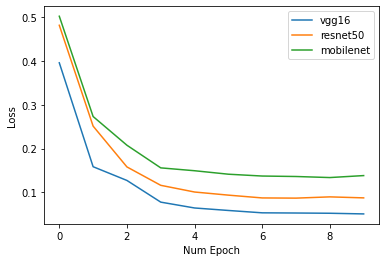

In [7]:
%%time
backbones = ['vgg16', 'resnet50', 'mobilenet']
for i,backbone in enumerate(backbones):
    print('backbone architecture: '+backbone)
    # model = torch.load('model.pth')
    model = get_model(backbone)
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
    num_epochs = 10
    losses = []

    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        loss = train_one_epoch(model, optimizer, data_loader_train, device, epoch)
        # update the learning rate
        lr_scheduler.step()
        losses.append(loss)
        torch.cuda.empty_cache()
        print(loss)
    # plt.subplot(1,3,i+1)
    plt.plot(list(range(num_epochs)), losses, label=backbone)
    torch.save(model, 'model_'+backbone+'.pth')
plt.xlabel("Num Epoch")
plt.ylabel("Loss")
plt.legend()

In [8]:
%%time
metrics = {}
backbones = ['vgg16', 'resnet50', 'mobilenet']
for backbone in backbones:
    model = torch.load('model_'+backbone+'.pth')
    model.eval()
    model.to(device)
    preds = []
    target = []
    for images, targets in data_loader_test:
        with torch.no_grad():
            predicts = model(images)
        preds += predicts
        target += targets
    metric = MeanAveragePrecision()
    metric.update(preds, target)
    metric.compute()
    metric_dic = metric.compute()
    metrics[backbone] = {'map':metric_dic['map'].item(),'map50':metric_dic['map_50'].item(),'map75':metric_dic['map_75'].item()}
    # pprint(metric.compute())
rslts = pd.DataFrame(data=metrics)
print(rslts)

          vgg16  resnet50  mobilenet
map    0.873106  0.768895   0.554168
map50  1.000000  0.975529   0.883351
map75  1.000000  0.938944   0.608311
CPU times: user 34.4 s, sys: 9.63 s, total: 44 s
Wall time: 38.4 s


CPU times: user 1.15 s, sys: 454 ms, total: 1.6 s
Wall time: 1.24 s


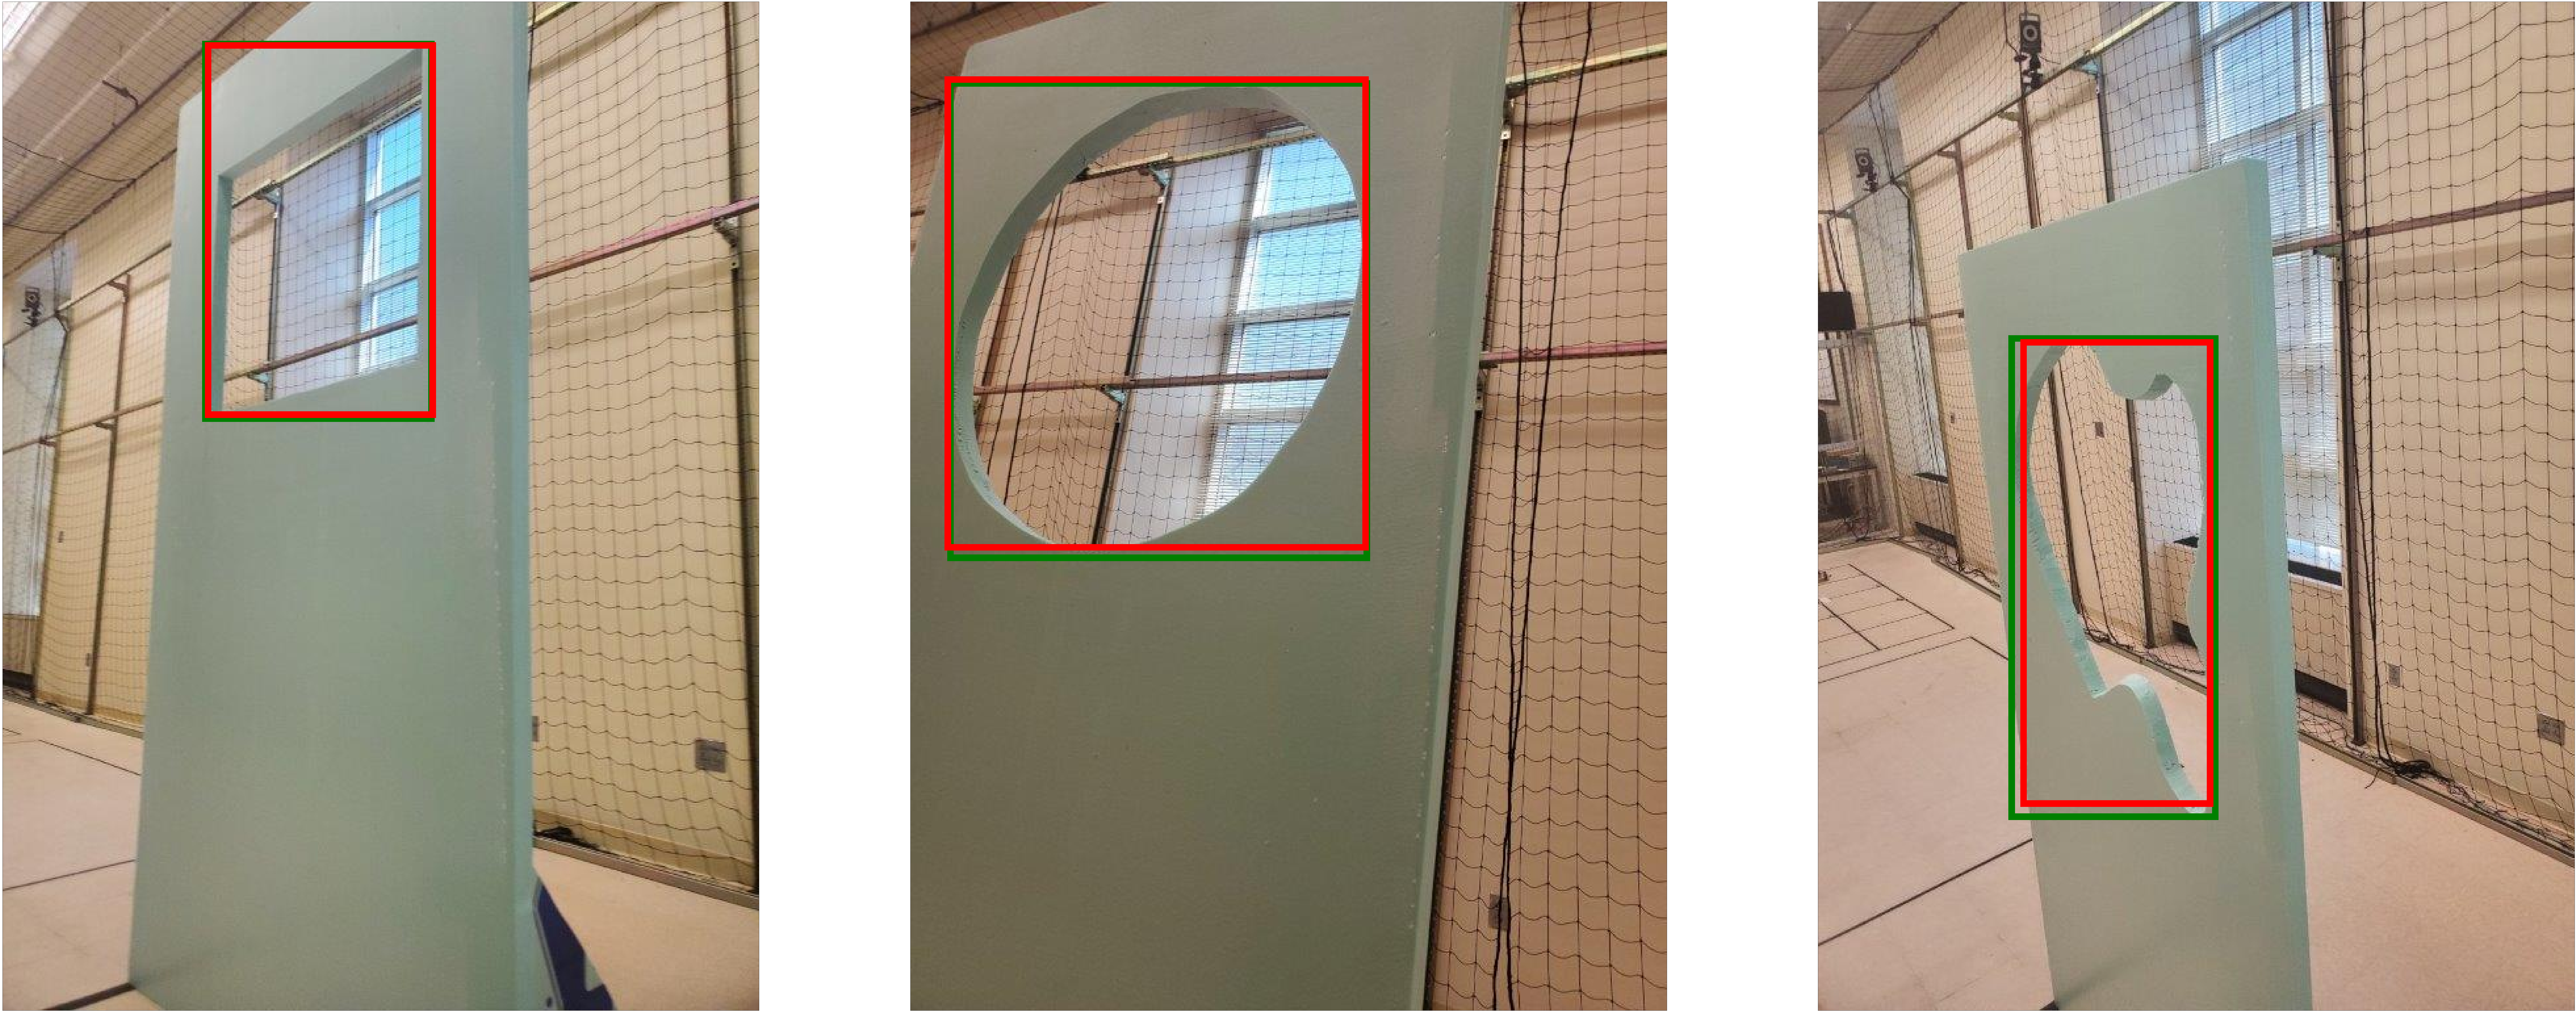

In [9]:
%%time
model = torch.load('model_vgg16.pth')
indices = torch.randperm(len(dataset_test)).tolist()
images = []
colors = ["green", "red"] # green for ground truth and red for predicted
model.eval()
model.to(device)
for idx in indices[:3]:
    # pick one image from the test set
    img, target = dataset_test[idx]
    # put the model in evaluation mode
    with torch.no_grad():
        prediction = model([img])
    image_id = target['image_id'].cpu().numpy()[0]
    file_name = label_df['file name'][image_id]
    img = read_image('./image_data/'+file_name)
    boxes = []
    boxes = target['boxes'][0].cpu()
    boxes = torch.vstack((boxes, prediction[0]['boxes'].cpu()[0]))
    img = draw_bounding_boxes(img, boxes, colors=colors, width=5)
    images.append(img)
show(images)